# BEMB Demo: Simulation Study 

> Author: Tianyu Du; Aug. 9, 2023

In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
from torch_choice.data import ChoiceDataset
from bemb.model import LitBEMBFlex
from bemb.utils.run_helper import run
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [3]:
# for reproducibility, fix random seeds.
random.seed(1234)
np.random.seed(1234)
torch.random.manual_seed(1234)

In [4]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
print(f"Using {DEVICE} device.")

Using cuda device.


In [5]:
# control the quality of figures. Use 75 for preview, use 300 for publication.
DPI = 75

In [6]:
num_users = 1_500  # 1500 users in the dataset.
num_items = 50  # 50 items to choose from.
num_sessions = 10  # 10 days.
data_size = 10_000

In [7]:
user_index = torch.LongTensor(np.random.choice(num_users, size=data_size))
session_index = torch.LongTensor(np.random.choice(num_sessions, size=data_size))

# Simulation Study 1: Item-Level "Random" Effect on User Attributes

## Simulate Dataset
We first specify the number of users and number of items in the dataset.
The `data_size` denotes the number of user-item choice pairs to generate (i.e., number of observations.)
Each user-item choice pair is called a **purchasing record** in our terminology, you can revise the data management tutorial.

## Simulate User Preferences

In [8]:
user_income = (torch.randn(num_users) + 5).clamp(min=0)
user_age = (torch.rand(num_users, dtype=torch.float) * 30 + 18)
user_gender = (torch.rand(num_users) > 0.5).long()

In [9]:
item_price = torch.rand(num_items) * 50 + 50
item_bin_cate = torch.zeros(num_items).long()
item_bin_cate[:25] = 1

In [10]:
def plot_tensor(tensor):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    sns.histplot(tensor.view(-1,).numpy(), bins=40, ax=ax)
    fig.show()

In our first simulation case, the utility $\mu_{uis}$ is a function of user-income with item-specific coefficient.

$$
\mu_{uis} = \beta_i \times x^\text{user income}_u
$$

The item-specific coefficient $\beta_i$ is generated as a stochastic function of item prices.

For high price items, income boost utility (e.g., luxury items).

For low price items, low income boost utility.

/var/folders/r3/rj0t5xcj557855yt3xr0qwnh0000gn/T/ipykernel_20079/259992804.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


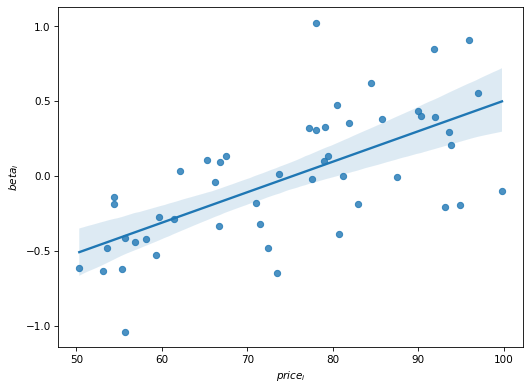

In [15]:
scaled_price = (item_price - torch.min(item_price))/ (torch.max(item_price) - torch.min(item_price)) - 0.5
beta_item = torch.randn_like(scaled_price)*torch.std(scaled_price) + scaled_price

fig, ax = plt.subplots(figsize=(8, 6), dpi=DPI)
sns.regplot(x=item_price.squeeze().numpy(), y=beta_item.numpy(), ax=ax)
ax.set_xlabel("$price_i$")
ax.set_ylabel("$beta_i$")
fig.savefig('./simulation_files/simulation_1_income_coefficients.png', dpi=DPI, bbox_inches='tight')
fig.show()

In [16]:
# user_random_effect = torch.randn(num_users)

In [17]:
utility = torch.zeros(num_users, num_items, num_sessions)
for u in tqdm(range(num_users)):
    for i in range(num_items):
        for s in range(num_sessions):
            utility[u, i, s] = beta_item[i] * user_income[u]

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [00:06<00:00, 246.14it/s]


/var/folders/r3/rj0t5xcj557855yt3xr0qwnh0000gn/T/ipykernel_20079/2673710228.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


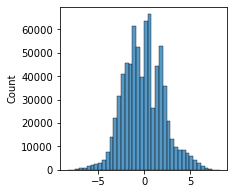

In [18]:
plot_tensor(utility)

## Generate Random Choices based on Preferences

In [19]:
item_index = torch.empty(data_size, dtype=torch.long)
for idx in tqdm(range(data_size)):
    u = user_index[idx]
    s = session_index[idx]
    utility_list = utility[u, :, s]
    p = torch.softmax(utility_list, dim=0).numpy()
    item_chosen = np.random.choice(num_items, p=p)
    item_index[idx] = item_chosen

# report most bought and least bought items.
vc = pd.DataFrame(data={"item": item_index.squeeze().numpy()}).value_counts(normalize=True).sort_values(ascending=False)
print("Most bought item:")
print(vc.head())
print("Least bought item:")
print(vc.tail())

100%|██████████| 10000/10000 [00:00<00:00, 30175.85it/s]

Most bought item:
item
46      0.3505
48      0.1966
29      0.1457
15      0.0472
0       0.0349
dtype: float64
Least bought item:
item
27      0.0003
39      0.0002
30      0.0002
3       0.0002
2       0.0001
dtype: float64


## Build Choice Dataset
Please refer to our `torch-choice` paper for more details.

In [28]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
print(f"Using device: {DEVICE}.")

Using device: cpu.


In [29]:
dataset = ChoiceDataset(user_index=user_index,
                        item_index=item_index,
                        session_index=session_index,
                        item_availability=None,  # everything is available.
                        # observables.
                        user_income=user_income.view(num_users, 1),
                        user_age=user_age.view(num_users, 1),
                        user_gender=user_gender.view(num_users, 1),
                        item_price=item_price.view(num_items, 1),
                        item_bin_cate=item_bin_cate).to(DEVICE)


# split dataset into train, val, test.
idx = np.random.permutation(len(dataset))
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
train_idx = idx[:train_size]
val_idx = idx[train_size: train_size + val_size]
test_idx = idx[train_size + val_size:]

dataset_list = [dataset[train_idx], dataset[val_idx], dataset[test_idx]]

In [30]:
dataset

ChoiceDataset(label=[], item_index=[10000], user_index=[10000], session_index=[10000], item_availability=[], user_income=[1500, 1], user_age=[1500, 1], user_gender=[1500, 1], item_price=[50, 1], item_bin_cate=[50], device=cpu)

## Fit A Model

In [39]:
# def fit_model(obs2prior: bool):
LATENT_DIM = 10  # the dimension of alpha and theta.
bemb = LitBEMBFlex(
    model_optimizer="Adam",
    learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
    pred_item=True,  # let the model predict item_index, don't change this one.
    num_seeds=128,  # number of Monte Carlo samples for estimating the ELBO.
    utility_formula='beta_item * user_income',  # the utility formula.
    num_users=num_users,
    num_items=num_items,
    trace_log_q=True,
    # num_user_obs=dataset.user_obs.shape[1],
    # num_item_obs=dataset.item_obs.shape[1],
    # whether to turn on obs2prior for each parameter.
    obs2prior_dict={'beta_item': False},
    # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
    # the same dimension.
    coef_dim_dict={'beta_item': 1},
    # prior_variance=1_000,
    # prior_mean=0.6
)

# use GPU if available.
bemb = bemb.to(DEVICE)
    
# use the provided run helper to train the model.
# we set batch size to be 5% of the data size, and train the model for 10 epochs.
# there would be 20*10=200 gradient update steps in total.
bemb = bemb.fit_model(dataset_list, batch_size=256, num_epochs=3, num_workers=0, device=DEVICE, enable_progress_bar=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tianyudu/miniforge3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 100   
-----------------------------------
100       Trainable params
0         Non-trainable params
100       Total params
0.000     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['beta_item'], 'observable': 'user_income'}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = beta_item * user_income
Total number of parameters: 100.
With the following coefficients:
ModuleDict(
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(label=[], item_index=[8000], user_index=[8000], session_index=[8000], item_availability=[], user_income=[1500, 1], user_age=[1500, 1], user_gender=[1500, 1], item_price=[50, 1], item_bin_cate=[50], device=cpu)
[Validation dataset] ChoiceDataset(label=[], item_index=[1000], user_index=[1000], session_index=[1000], item_availability=[], user_income=[1500, 1], user_age=[1500, 1], user_gender=[1500, 1], item_price=[50, 1], item_bin_cate=[50], device=cpu)
[Testing dataset] ChoiceD

/Users/tianyudu/miniforge3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/tianyudu/miniforge3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2: 100%|██████████| 36/36 [00:01<00:00, 29.36it/s, loss=1.06e+03, v_num=10, val_acc=0.353, val_ll=-2.69]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 36/36 [00:01<00:00, 29.28it/s, loss=1.06e+03, v_num=10, val_acc=0.353, val_ll=-2.69]

/Users/tianyudu/miniforge3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



time taken: 3.5852210521698
==================== test performance ====================
Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 345.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.357           │
│          test_ll          │    -2.5526849286556246    │
└───────────────────────────┴───────────────────────────┘

## Comparison $\beta_i$ and $\hat{\beta}_i$ for items.

real.shape=(50,), pred.shape=(50,)


/var/folders/r3/rj0t5xcj557855yt3xr0qwnh0000gn/T/ipykernel_20079/3433393549.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


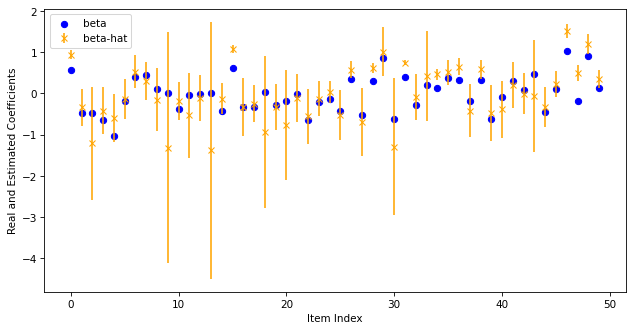

In [40]:
real = beta_item.squeeze().numpy()
pred = bemb.state_dict()["coef_dict.beta_item.variational_mean_flexible"].squeeze().numpy()
err = 1.96 * bemb.state_dict()["coef_dict.beta_item.variational_logstd"].squeeze().exp()

print(f"{real.shape=:}, {pred.shape=:}")
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)
ax.scatter(np.arange(num_items), real, label="beta", marker="o", color="blue")
# ax.scatter(np.arange(num_items), pred, label="beta-hat", marker="x")
ax.errorbar(np.arange(num_items), y=pred, yerr=err, label="beta-hat", marker="x", linestyle='none', color="orange")

# for i in range(num_items):
#     a = real[i]
#     b = pred[i]
#     ax.axvline(i, ymin=min(a, b), ymax=max(a, b), color="black", alpha=0.5)

ax.set_xlabel("Item Index")
ax.set_ylabel("Real and Estimated Coefficients")
ax.legend()
fig.savefig("simulation_files/simulation_1_beta_hat.png", dpi=DPI, bbox_inches="tight")
fig.show()

# Simulation Study 2: More Complicated Item-Specific Effects (Obs2Prior)

In [22]:
item_obs=torch.cat([item_price.view(num_items, 1), item_bin_cate.view(num_items, 1)], dim=1)

In [23]:
item_obs.shape

torch.Size([50, 2])

In [24]:
item_bin_cate = item_bin_cate.squeeze()

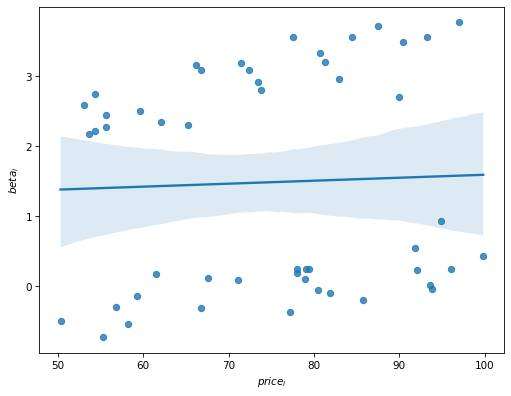

In [32]:
scaled_price = (item_price - torch.min(item_price))/ (torch.max(item_price) - torch.min(item_price)) - 0.5
beta_item = torch.randn_like(scaled_price)*torch.std(scaled_price) + scaled_price

for i in range(num_items):
    if item_bin_cate[i] == 1:
        beta_item[i] = beta_item[i] + 3

fig, ax = plt.subplots(figsize=(8, 6), dpi=DPI)
sns.regplot(x=item_price.squeeze().numpy(), y=beta_item.numpy(), ax=ax)
ax.set_xlabel("$price_i$")
ax.set_ylabel("$beta_i$")
fig.savefig('./simulation_files/simulation_2_income_coefficients.png', dpi=DPI, bbox_inches='tight')
fig.show()

In [33]:
utility = torch.zeros(num_users, num_items, num_sessions)
for u in tqdm(range(num_users)):
    for i in range(num_items):
        for s in range(num_sessions):
            utility[u, i, s] = beta_item[i] * user_income[u]

100%|██████████| 1500/1500 [00:03<00:00, 376.36it/s]


In [34]:
item_index = torch.empty(data_size, dtype=torch.long)
for idx in tqdm(range(data_size)):
    u = user_index[idx]
    s = session_index[idx]
    utility_list = utility[u, :, s]
    p = torch.softmax(utility_list, dim=0).numpy()
    item_chosen = np.random.choice(num_items, p=p)
    item_index[idx] = item_chosen

100%|██████████| 10000/10000 [00:00<00:00, 28678.79it/s]


In [35]:
item_index

tensor([15, 11,  0,  ...,  0,  0, 23])

In [36]:
dataset = ChoiceDataset(user_index=user_index,
                        item_index=item_index,
                        session_index=session_index,
                        item_availability=None,  # everything is available.
                        # observables.
                        user_income=user_income.view(num_users, 1),
                        user_age=user_age.view(num_users, 1),
                        user_gender=user_gender.view(num_users, 1),
                        item_price=item_price.view(num_items, 1),
                        item_bin_cate=item_bin_cate,
                        item_obs=item_obs
                        ).to(DEVICE)


# split dataset into train, val, test.
idx = np.random.permutation(len(dataset))
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
train_idx = idx[:train_size]
val_idx = idx[train_size: train_size + val_size]
test_idx = idx[train_size + val_size:]

dataset_list = [dataset[train_idx], dataset[val_idx], dataset[test_idx]]

In [37]:
dataset

ChoiceDataset(label=[], item_index=[10000], user_index=[10000], session_index=[10000], item_availability=[], user_income=[1500, 1], user_age=[1500, 1], user_gender=[1500, 1], item_price=[50, 1], item_bin_cate=[50], item_obs=[50, 2], device=cuda:0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 104   
-----------------------------------
104       Trainable params
0         Non-trainable params
104       Total params
0.000     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['beta_item'], 'observable': 'user_income'}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = beta_item * user_income
Total number of parameters: 104.
With the following coefficients:
ModuleDict(
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(H*X_obs(H shape=torch.Size([1, 2]), X_obs shape=2), Ix1))
)
[]
Optimizer: Adam, Learning rate: 0.3
==================== data set received ====================
[Training dataset] ChoiceDataset(label=[], item_index=[8000], user_index=[8000], session_index=[8000], item_availability=[], user_income=[1500, 1], user_age=[1500, 1], user_gender=[1500, 1], item_price=[50, 1], item_bin_cate=[50], item_obs=[50, 2], device=cuda:0)
[Validation dataset] ChoiceDataset(label=[], item_index=[1000], user_index=[1000], session_index=[1000], item_availability=[], user_income=[1500, 1], user_age=[1500, 1], user_gender=[1500, 1], item_p

/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=40` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.s

time taken: 14.865919351577759
==================== test performance ====================


/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.216           │
│          test_ll          │    -2.2522530767917632    │
└───────────────────────────┴───────────────────────────┘

real.shape=(50,), pred.shape=(50,)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 100   
-----------------------------------
100       Trainable params
0         Non-trainable params
100       Total params
0.000     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['beta_item'], 'observable': 'user_income'}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = beta_item * user_income
Total number of parameters: 100.
With the following coefficients:
ModuleDict(
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.3
==================== data set received ====================
[Training dataset] ChoiceDataset(label=[], item_index=[8000], user_index=[8000], session_index=[8000], item_availability=[], user_income=[1500, 1], user_age=[1500, 1], user_gender=[1500, 1], item_price=[50, 1], item_bin_cate=[50], item_obs=[50, 2], device=cuda:0)
[Validation dataset] ChoiceDataset(label=[], item_index=[1000], user_index=[1000], session_index=[1000], item_availability=[], user_income=[1500, 1], user_age=[1500, 1], user_gender=[1500, 1], item_price=[50, 1], item_bin_cate=[50], item_obs=[50, 2],

/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=40` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.s

time taken: 13.055980920791626
==================== test performance ====================


/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.251           │
│          test_ll          │    -2.3237849240005017    │
└───────────────────────────┴───────────────────────────┘

real.shape=(50,), pred.shape=(50,)


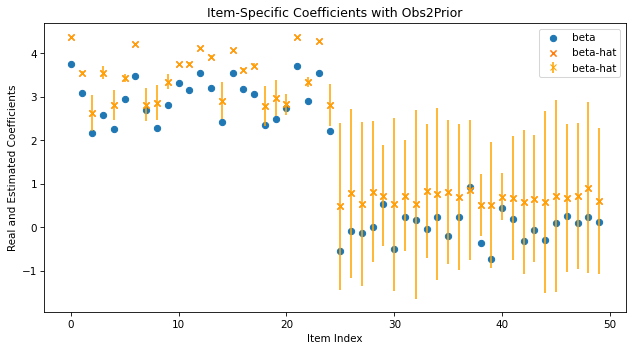

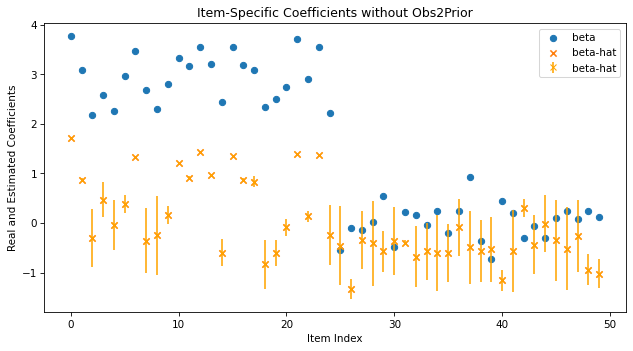

In [48]:
for enable_obs2prior in [True, False]:
    # def fit_model(obs2prior: bool):
    LATENT_DIM = 10  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        model_optimizer="Adam",
        learning_rate=0.3,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='beta_item * user_income',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        trace_log_q=True,
        # num_user_obs=dataset.user_obs.shape[1],
        num_item_obs=dataset.item_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'beta_item': enable_obs2prior},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'beta_item': 1},
        prior_variance={'beta_item': 1},
    )

    # use GPU if available.
    bemb = bemb.to(DEVICE)
 
    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = bemb.fit_model(dataset_list, batch_size=128, num_epochs=40, num_workers=0, device=DEVICE, enable_progress_bar=False)

    real = beta_item.squeeze().numpy()
    pred = bemb.state_dict()["coef_dict.beta_item.variational_mean_flexible"].squeeze().numpy()
    err = 1.96 * bemb.state_dict()["coef_dict.beta_item.variational_logstd"].squeeze().exp()

    print(f"{real.shape=:}, {pred.shape=:}")
    fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)
    ax.scatter(np.arange(num_items), real, label="beta", marker="o")
    ax.scatter(np.arange(num_items), pred, label="beta-hat", marker="x")
    ax.errorbar(np.arange(num_items), y=pred, yerr=err, label="beta-hat", marker="x", linestyle='none', color="orange")


    ax.set_xlabel("Item Index")
    ax.set_ylabel("Real and Estimated Coefficients")
    ax.legend()

    if enable_obs2prior:
        ax.set_title("Item-Specific Coefficients with Obs2Prior")
    else:
        ax.set_title("Item-Specific Coefficients without Obs2Prior")
    fig.savefig(f"simulation_files/simulation_2_beta_hat_obs2prior={enable_obs2prior}.png")
    fig.show()

# Simulation Study 3: User Latent and Item Latent Interactions

## User Specific Preferences

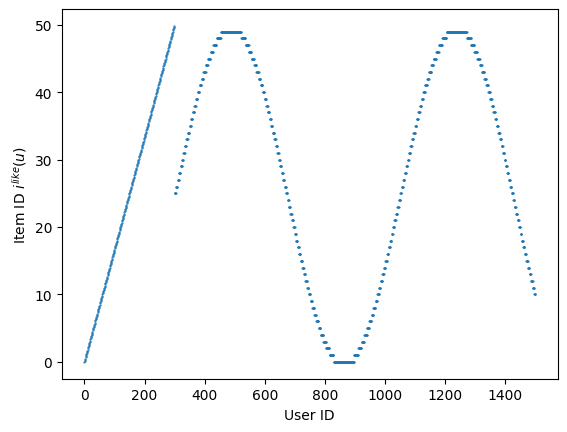

In [11]:
# Us = np.arange(int(0.8*num_users))
Is = np.sin(np.arange(int(0.8*num_users)) / num_users * 4 * np.pi)
Is = (Is + 1) / 2 * num_items
Is = Is.astype(int)

Us = np.arange(num_users)
Is = np.concatenate([
    np.arange(int(0.2*num_users)) * num_items / (0.2*num_users),
    Is
])

PREFERENCE = dict((u, i) for (u, i) in zip(Us, Is))

plt.close()
plt.scatter(Us, Is, s=0.3)
plt.xlabel('User ID')
plt.ylabel('Item ID $i^{like}(u)$')
plt.savefig('./simulation_files/simulation_3_user_preferences.png', dpi=DPI, bbox_inches='tight')
plt.show()

To add some randomness, for each purchasing records, with 50\% chance, user $u$ chooses the item $i^*(u)$ she loves, and with 50\% of chance she chooses an item randomly.

In [12]:
# construct users.
item_index = torch.LongTensor(np.random.choice(num_items, size=data_size))
user_bin_cate = torch.zeros(num_users).long()
user_bin_cate[:100] = 1
user_bin_cate[200:num_users // 2] = 1

for idx in range(data_size):
    # follows random behaviors.
    rnd = np.random.rand()
    if user_bin_cate[int(user_index[idx])] == 0:
        if rnd <= 0.5:
            item_index[idx] = PREFERENCE[int(user_index[idx])]
        # elif rnd <= 0.8:
        #     item_index[idx] = min(49, num_items - PREFERENCE[int(user_index[idx])])
    else:
        if rnd <= 0.5:
            item_index[idx] = min(49, num_items - PREFERENCE[int(user_index[idx])])
        # elif rnd <= 0.8:
        #     item_index[idx] = PREFERENCE[int(user_index[idx])]

To have a visual inspection on the preference we added, we can plot a heat map indexed by (user, item) and visualize the frequency of bought items by each user. In the heat map below, each row represents the empirical distribution of items (x-axis) bought. Warmer color (red) indicates high purchasing frequencies, which shows the synthetic sin-curve of preference we enforced above.

/tmp/ipykernel_3599/1132628072.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.pivot('item', 'user', 'size').fillna(0.0)


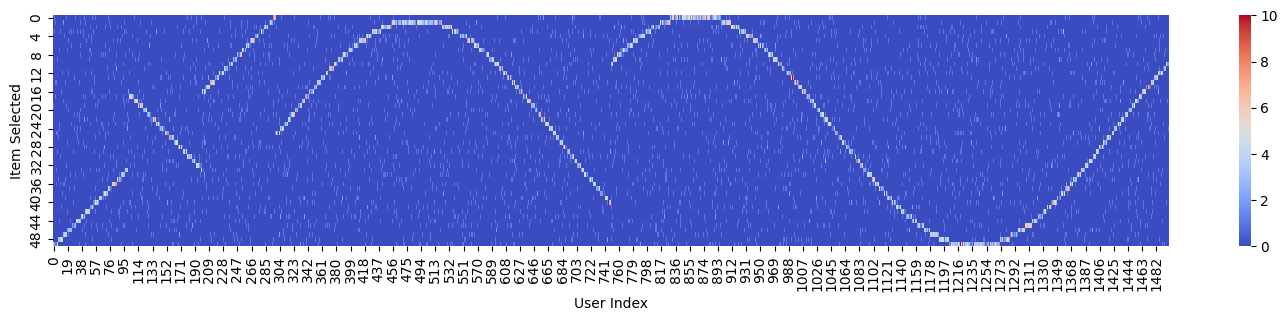

In [13]:
df = pd.DataFrame(data={'item': item_index, 'user': user_index}).groupby(['item', 'user']).size().rename('size').reset_index()
df = df.pivot('item', 'user', 'size').fillna(0.0)

fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(df.values, square=False, ax=ax, cmap='coolwarm')
ax.set(xlabel='User Index', ylabel='Item Selected')
fig.savefig("./simulation_files/simulation_3_heatmap.png", dpi=DPI, bbox_inches="tight")
fig.show()

In [14]:
user_obs = torch.zeros(num_users, num_items)
user_obs[torch.arange(num_users), Is] = 1
# user_obs = torch.cat([user_obs, user_bin_cate.view(-1, 1)], dim=1)
# user_obs = torch.cat([user_obs, user_bin_cate.view(-1, 1)], dim=1)

user_obs = torch.eye(num_users)
# user_obs = user_bin_cate.view(-1, 1)
item_obs = torch.eye(num_items)

dataset = ChoiceDataset(user_index=user_index, item_index=item_index, user_obs=user_obs, item_obs=item_obs)

idx = np.random.permutation(len(dataset))
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
train_idx = idx[:train_size]
val_idx = idx[train_size: train_size + val_size]
test_idx = idx[train_size + val_size:]

dataset_list = [dataset[train_idx], dataset[val_idx], dataset[test_idx]]

No `session_index` is provided, assume each choice instance is in its own session.


## Fitting the Model
We will be fitting a Bayesian matrix factorization model with utility form

$$
\mathcal{U}_{u, i} = \theta_u^\top \alpha_i
$$
where $\theta_u$ and $\alpha_i$ are Bayesian variables. Please refer to the BEMB tutorial for a detailed description on how this kind of model works.

There are two options on the prior distributions of these Bayesian variables $\theta_u$ and $\alpha_i$. Firstly, we can simply use standard Gaussian as the prior distribution:

$$
\theta_u \overset{prior}{\sim} \mathcal{N}(\mathbf{0}, I) \quad
\alpha_i \overset{prior}{\sim} \mathcal{N}(\mathbf{0}, I)
$$

Alternatively, the prior can be chosen using a data-driven method called `obs2prior`. In particular, the mean of prior distribution can be a learnable linear function of user/item observables. Let $X^{(user)}_u$ and $X^{(item)}_i$ denote the observables of user $u$ and item $i$ respectively. The `obs2prior`-augmented prior distribution is the following: 

$$
\theta_u \overset{prior}{\sim} \mathcal{N}(H X^{(user)}_u, I) \quad
\alpha_i \overset{prior}{\sim} \mathcal{N}(W X^{(item)}_i, I)
$$

where $H$ and $W$ are two learnable parameters.

In [45]:
def fit_model(obs2prior: bool):
    LATENT_DIM = 10  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='theta_user * alpha_item',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        num_user_obs=dataset.user_obs.shape[1],
        num_item_obs=dataset.item_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'theta_user': obs2prior, 'alpha_item': False},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'theta_user': LATENT_DIM, 'alpha_item': LATENT_DIM}
    )

    # use GPU if available.
    if torch.cuda.is_available():
        bemb = bemb.to('cuda')
       
    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = bemb.fit_model(dataset_list, batch_size=128, num_epochs=100, num_workers=0, device=DEVICE, enable_progress_bar=False)

    # visualize the prediction.
    T = bemb.model.coef_dict['theta_user'].variational_mean_flexible.data
    A = bemb.model.coef_dict['alpha_item'].variational_mean_flexible.data
    fig, ax = plt.subplots(figsize=(18, 3))
    sns.heatmap((A @ T.T).numpy(), square=False, ax=ax, cmap='coolwarm')
    if obs2prior:
        ax.set_title("User-Item Interaction Utility with Obs2Prior")
    else:
        ax.set_title("User-Item Interaction Utility without Obs2Prior")
    fig.savefig(f"simulation_files/simulation_3_interaction_hat_obs2prior={obs2prior}.png", dpi=DPI, bbox_inches="tight")
    fig.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 61.0 K
-----------------------------------
61.0 K    Trainable params
0         Non-trainable params
61.0 K    Total params
0.244     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['theta_user', 'alpha_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = theta_user * alpha_item
Total number of parameters: 61000.
With the following coefficients:
ModuleDict(
  (theta_user): BayesianCoefficient(num_classes=1500, dimension=10, prior=N(H*X_obs(H shape=torch.Size([10, 1500]), X_obs shape=1500), Ix1.0))
  (alpha_item): BayesianCoefficient(num_classes=50, dimension=10, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(label=[], item_index=[8000], user_index=[8000], session_index=[8000], item_availability=[], user_obs=[1500, 1500], item_obs=[50, 50], device=cpu)
[Validation dataset] ChoiceDataset(label=[], item_index=[1000], user_index=[1000], session_index=[1000], item_availability=[], user_obs=[1500, 1500], item_obs=[50, 50], device=cpu)


/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.

time taken: 62.888338804244995
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.381           │
│          test_ll          │    -4.067364019381348     │
└───────────────────────────┴───────────────────────────┘

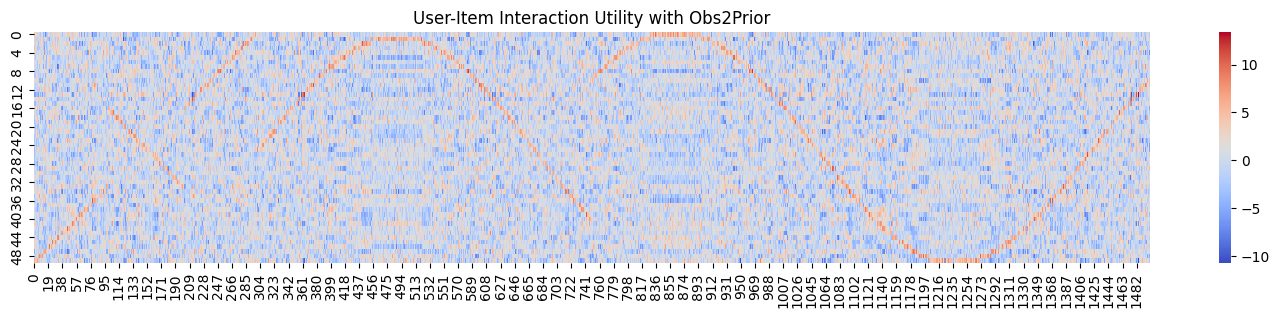

In [46]:
fit_model(obs2prior=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 31.0 K
-----------------------------------
31.0 K    Trainable params
0         Non-trainable params
31.0 K    Total params
0.124     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['theta_user', 'alpha_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = theta_user * alpha_item
Total number of parameters: 31000.
With the following coefficients:
ModuleDict(
  (theta_user): BayesianCoefficient(num_classes=1500, dimension=10, prior=N(0, I))
  (alpha_item): BayesianCoefficient(num_classes=50, dimension=10, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(label=[], item_index=[8000], user_index=[8000], session_index=[8000], item_availability=[], user_obs=[1500, 1500], item_obs=[50, 50], device=cpu)
[Validation dataset] ChoiceDataset(label=[], item_index=[1000], user_index=[1000], session_index=[1000], item_availability=[], user_obs=[1500, 1500], item_obs=[50, 50], device=cpu)
[Testing dataset] ChoiceDataset(label=[], item_index=[1000],

/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.

time taken: 60.16082715988159
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.031           │
│          test_ll          │    -3.912008135318756     │
└───────────────────────────┴───────────────────────────┘

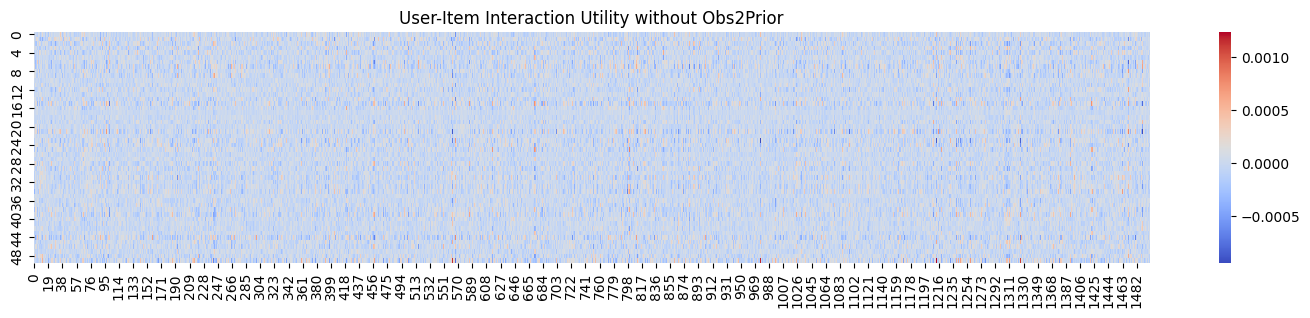

In [47]:
fit_model(obs2prior=False)

Now we compare the difference between two options of prior distributions. We provide a `fit_model` helper function to train and visualize the model. You can go through `fit_model` method to have a preliminary understanding on how to train a BEMB model.

**Visualization**: The method visualize the fitted model by plotting $\theta_u^\top \alpha_i$ for all pairs of user $u$ and item $i$ on a heat map. The sine-curve on the heat map indicates the model successfully recovered the preference pattern we added.

# Simulation Study 4: User Latent and Item Latent Coefficient

In [15]:
magnitude = 5
theta = torch.empty(num_users, num_items)
for u in range(num_users):
    for i in range(num_items):
        diff = np.abs(i - (PREFERENCE[u])) / 100
        theta[u, i] = 1/(1 + np.exp(-diff))
        theta[u, i] = magnitude * theta[u, i] - 2.8

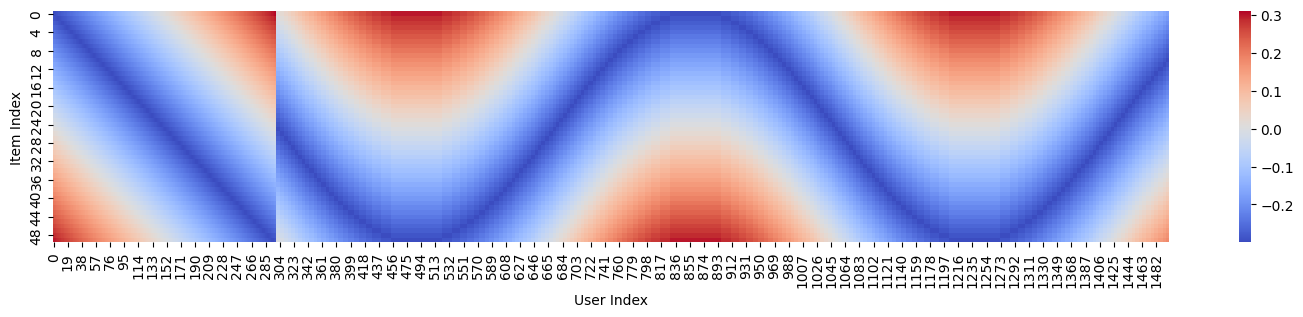

In [16]:
fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(theta.T, square=False, ax=ax, cmap='coolwarm')
ax.set(xlabel='User Index', ylabel='Item Index')
fig.savefig("./simulation_files/simulation_4_coefficients.png", dpi=DPI, bbox_inches="tight")
fig.show()

In [17]:
session_obs = (torch.randn(num_sessions) + 1) * 100

In [18]:
utility = torch.zeros(num_users, num_items, num_sessions)
for u in tqdm(range(num_users)):
    for i in range(num_items):
        for s in range(num_sessions):
            utility[u, i, s] = theta[u, i] * session_obs[s]

item_index = torch.empty(data_size, dtype=torch.long)
for idx in tqdm(range(data_size)):
    u = user_index[idx]
    s = session_index[idx]
    utility_list = utility[u, :, s]
    p = torch.softmax(utility_list, dim=0).numpy()
    item_chosen = np.random.choice(num_items, p=p)
    item_index[idx] = item_chosen

# report most bought and least bought items.
vc = pd.DataFrame(data={"item": item_index.squeeze().numpy()}).value_counts(normalize=True).sort_values(ascending=False)
print("Most bought item:")
print(vc.head())
print("Least bought item:")
print(vc.tail())

100%|██████████| 10000/10000 [00:00<00:00, 27709.08it/s]

Most bought item:
item
0       0.3179
49      0.2240
1       0.0843
48      0.0566
2       0.0370
dtype: float64
Least bought item:
item
22      0.0033
12      0.0032
30      0.0030
21      0.0028
19      0.0028
dtype: float64


In [19]:
user_obs = torch.zeros(num_users, num_items)
user_obs[torch.arange(num_users), Is] = 1

In [20]:
dataset = ChoiceDataset(user_index=user_index, item_index=item_index, user_obs=user_obs, item_obs=item_obs, session_index=session_index, session_obs=session_obs.view(num_sessions, 1))

idx = np.random.permutation(len(dataset))
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
train_idx = idx[:train_size]
val_idx = idx[train_size: train_size + val_size]
test_idx = idx[train_size + val_size:]

dataset_list = [dataset[train_idx], dataset[val_idx], dataset[test_idx]]

In [36]:
def fit_model(obs2prior: bool):
    LATENT_DIM = 5  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='theta_user * alpha_item * session_obs',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        num_sessions=num_sessions,
        num_user_obs=dataset.user_obs.shape[1],
        num_item_obs=dataset.item_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'theta_user': obs2prior, 'alpha_item': False},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'theta_user': LATENT_DIM, 'alpha_item': LATENT_DIM}
    )

    # use GPU if available.
    if torch.cuda.is_available():
        bemb = bemb.to('cuda')
       
    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = bemb.fit_model(dataset_list, batch_size=128, num_epochs=300, num_workers=0, device=DEVICE, enable_progress_bar=False)

    # visualize the prediction.
    T = bemb.model.coef_dict['theta_user'].variational_mean_flexible.data
    A = bemb.model.coef_dict['alpha_item'].variational_mean_flexible.data
    fig, ax = plt.subplots(figsize=(18, 3))
    sns.heatmap((A @ T.T).numpy(), square=False, ax=ax, cmap='coolwarm')
    if obs2prior:
        ax.set_title("User-Item Interaction Utility with Obs2Prior")
    else:
        ax.set_title("User-Item Interaction Utility without Obs2Prior")
    fig.savefig(f"simulation_files/simulation_4_interaction_hat_obs2prior={obs2prior}.png", dpi=DPI, bbox_inches="tight")
    fig.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 16.0 K
-----------------------------------
16.0 K    Trainable params
0         Non-trainable params
16.0 K    Total params
0.064     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['theta_user', 'alpha_item'], 'observable': 'session_obs'}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = theta_user * alpha_item * session_obs
Total number of parameters: 16000.
With the following coefficients:
ModuleDict(
  (theta_user): BayesianCoefficient(num_classes=1500, dimension=5, prior=N(H*X_obs(H shape=torch.Size([5, 50]), X_obs shape=50), Ix1.0))
  (alpha_item): BayesianCoefficient(num_classes=50, dimension=5, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(label=[], item_index=[8000], user_index=[8000], session_index=[8000], item_availability=[], user_obs=[1500, 50], item_obs=[50, 50], session_obs=[10, 1], device=cpu)
[Validation dataset] ChoiceDataset(label=[], item_index=[1000], user_index=[1000], session_index=[1000], item_availability=[], user_obs=[1500, 50]

/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=300` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.

time taken: 140.29426741600037
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.513           │
│          test_ll          │    -1.6886294887973927    │
└───────────────────────────┴───────────────────────────┘

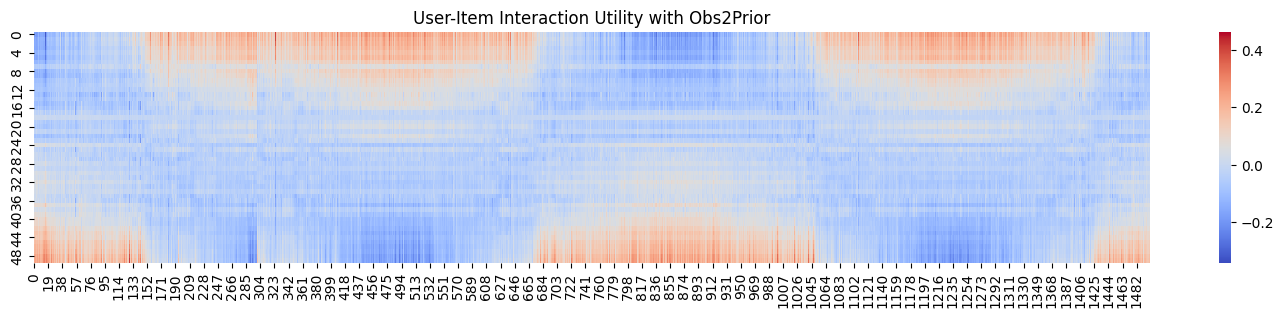

In [37]:
fit_model(True)

In [ ]:
fit_model(True)